# NN cascade for PPT

* Radek Hofman, 15/10/2019
* changed 9/5/2018 before meeting with SA

* we limit RETIME=0 to make sure we train on correct parameters
* correct output nodes (see node1-6 in the C code)
* corrected NAB, TAB values in training set, chaged datatypes in ML_FEATURES_CONTEXTUAL
* weights with suffix NTC Nab, Tab Correct
* copy of URZ_R2_correct_NABTAB.ipynb
* With normalization of Features as in iwt_nnet.c : iwt_normalize() 
* we restruict ourselves to data up to 2017/01/01 00:00 for training and validation, we test on data after 2017
* we use weighted cost function to put more focus on associated phases than on noise

https://datascience.stackexchange.com/questions/13490/how-to-set-class-weights-for-imbalanced-classes-in-keras

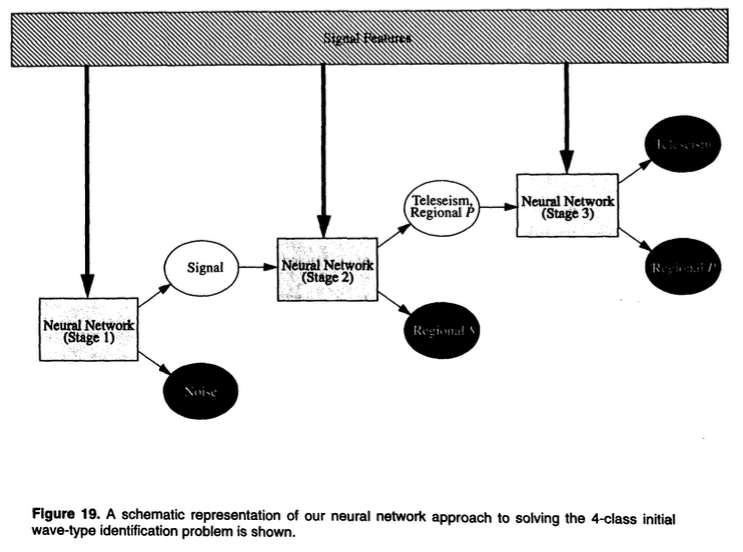

In [38]:
from IPython.display import Image
Image(filename=os.path.join('pics', 'StaPro_nn_cascade.png')) 

# The code  (re-training and evaluation)

### Imports and axiliary functions and stuff

In [1]:
%load_ext sql
%matplotlib inline

In [1]:
import os
import numpy
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import keras

/dvlscratch/SHI/users/hofman/ML/venv3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


In [2]:
with open(os.path.join('/','home','hofman','.dbpold.txt'), 'r') as f: password = f.read().strip()

In [3]:
STA = 'PPT'

In [4]:
query = "oracle://hofman[retraining]:%s@dba1091.qandef:1521" % password
%sql $query

UsageError: Line magic function `%sql` not found.


In [5]:
% sql select count(*) from ml_features where sta=STA

UsageError: Line magic function `%sql` not found.


In [6]:
def plot(history, semilog=False):
    fig = plt.figure()
    ax = fig.add_subplot(211)
    ax.plot(history['acc'], label='acc')
    ax.plot(history['val_acc'], label='val_acc')
    ax.set_ylabel('accuracy')
    if semilog:
        ax.set_yscale('log')
    plt.legend(loc='best')
    ax = fig.add_subplot(212)
    ax.plot(history['loss'], label='loss')
    ax.plot(history['val_loss'], label='val_loss')
    plt.legend(loc='best')
    if semilog:
        ax.set_yscale('log')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')

In [9]:
#load data from oracle do pandas
with open(os.path.join('/','home','hofman','.dbpold.txt'), 'r') as f: password_old = f.read().strip()
import cx_Oracle
connection = cx_Oracle.connect('hofman[retraining]', password_old, 'dba1091.qandef')

In [10]:
#connection.close()

### What is the misclassification rate now for all arrivals in our DB?

* #(class_iphase != class_phase) / (#automatic which are not noise) 

In [11]:
#select from database required numbers
#wrong_type = %sql select count(*) from ml_features where sta=STA and class_phase != class_iphase
#total_number = %sql select count(*) from ml_features where sta=STA and phase!='N' and source!='M'
#print('Percentage of misclassified initial wave types: %3.2f%%' % (wrong_type[0][0]/total_number[0][0]*100))

In [12]:
from datetime import datetime as dt

In [13]:
dt.fromtimestamp(1483228800)

datetime.datetime(2017, 1, 1, 0, 0)

In [14]:
ts_2017 = dt(2017,1,1,0,0,0).timestamp()
ts_2018 = dt(2018,1,1,0,0,0).timestamp()
ts_2019 = dt(2019,1,1,0,0,0).timestamp()

### Dataframes per class phase type - RESTRICTION TO DATA BEFORE 2018

In [15]:
query = f"select * from ml_features where sta='{STA}' and class_phase='regS' and time < {ts_2018}" # and# retime=0"
df_S_all = pd.read_sql(query, con=connection)

In [16]:
df_S_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,87222136,PPT,1.371265e+09,Lg,regS,Sn,regS,1.46,A,0.333333,...,1.960095,4.646625,4.428984,-0.2,-0.00635,0.345232,10.492494,5.540381,1.422131,1.398095
1,93024698,PPT,1.392498e+09,Sx,regS,Sn,regS,0.00,A,0.166667,...,2.046523,3.882053,4.766236,-0.3,-0.09720,0.361963,0.639523,1.131474,2.561463,4.169308
2,99214579,PPT,1.413312e+09,Rg,regS,Sn,regS,1.96,A,0.666667,...,3.964894,2.141665,1.334188,-0.1,-0.00460,1.137106,3.942555,0.804246,3.348041,7.982247
3,114320417,PPT,1.464535e+09,Sx,regS,Sn,regS,1.08,A,0.444444,...,2.578794,0.280057,4.188609,0.0,-0.40200,0.242751,2.555073,0.260043,1.413600,3.975286
4,126092901,PPT,1.504895e+09,Lg,regS,Sn,regS,0.52,A,0.444444,...,2.125847,2.199089,3.652081,-0.3,-0.03208,3.096228,7.788486,4.193873,1.063790,2.438190


In [17]:
df_S_all.shape

(7, 25)

In [18]:
query = f"select * from ml_features where sta='{STA}' and class_phase='regP' and time < {ts_2018}" #and retime=0"""
df_P_all = pd.read_sql(query, con=connection)

In [19]:
df_P_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,87222132,PPT,1.371265e+09,Pn,regP,Pn,regP,0.11265,A,0.166667,...,1.400944,0.203131,0.271114,0.6,0.321067,0.513616,1.879966,0.634354,0.424771,0.639397
1,93024694,PPT,1.392498e+09,Pn,regP,Pn,regP,0.00000,A,0.222222,...,3.182606,0.173067,0.248256,0.4,0.117440,0.319738,0.453798,1.382448,0.189662,0.530413
2,99214577,PPT,1.413312e+09,Pg,regP,Pn,regP,0.00000,A,0.444444,...,6.686378,0.099959,0.097741,0.3,0.253333,0.174218,1.452085,0.327567,0.119083,0.241826
3,103881646,PPT,1.429184e+09,Pn,regP,Pn,regP,0.00000,A,0.222222,...,3.070949,0.433317,0.430665,0.0,0.000000,2.634033,1.959322,0.846038,0.671450,0.391480
4,126092653,PPT,1.504895e+09,Pn,regP,Pn,regP,0.60000,A,0.166667,...,1.424078,0.305842,0.546541,0.7,0.275229,1.644694,4.221278,1.168747,1.061694,0.907079


In [20]:
df_P_all.shape

(10, 25)

In [21]:
query = f"select * from ml_features where sta='{STA}' and class_phase='T' and time < {ts_2018} and retime<4" #and retime=0
df_T_all = pd.read_sql(query, con=connection)

In [22]:
df_T_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,77456226,PPT,1.336990e+09,P,T,pP,T,0.90,A,1.000000,...,3.738755,0.198644,0.308210,0.1,-0.1519,0.048638,0.095881,1.091558,1.155428,1.759735
1,77569046,PPT,1.337355e+09,P,T,P,T,0.00,A,0.666667,...,4.472959,0.114623,0.227644,0.1,0.0460,0.985742,1.113038,0.652504,0.382680,1.123516
2,77629677,PPT,1.337554e+09,P,T,P,T,1.66,A,1.000000,...,4.019709,1.202457,0.138819,0.0,0.0000,0.517272,0.343504,0.344457,0.973332,2.285864
3,77802973,PPT,1.338182e+09,P,T,pP,T,0.00,A,0.666667,...,2.502040,0.143956,0.599184,0.1,0.0572,0.401740,0.545035,0.746908,0.859449,3.154078
4,77819442,PPT,1.338242e+09,P,T,P,T,0.00,A,0.333333,...,1.537113,0.134302,0.706407,0.0,0.0000,0.780530,2.447699,0.352861,0.231219,0.454590


In [23]:
df_T_all.shape

(3960, 25)

In [79]:
query = f"select * from ml_features where sta='{STA}' and class_phase='N' and time < {ts_2018}" # and source!='Z'"""
df_N_all = pd.read_sql(query, con=connection)

In [80]:
df_N_all.head()

,ARID,STA,TIME,IPHASE,CLASS_IPHASE,PHASE,CLASS_PHASE,RETIME,SOURCE,PER,...,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,12848502,PPT,1.053424e+09,N,N,None,N,0.0,A,1.000000,...,3.175871,2.539245,2.539245,0.0,0.0,0.221946,0.870189,0.630616,0.583791,0.642056
1,12848503,PPT,1.053424e+09,N,N,None,N,0.0,A,1.000000,...,2.257332,0.226766,0.231924,0.0,0.0,0.479348,0.511161,0.449191,0.497033,1.055950
2,12849806,PPT,1.053435e+09,N,N,None,N,0.0,A,0.444444,...,3.257640,1.656916,0.403881,0.0,0.0,0.285899,0.167555,1.112668,0.517749,0.998963
3,12851394,PPT,1.053448e+09,N,N,None,N,0.0,A,0.166667,...,2.084906,2.541952,2.541952,0.0,0.0,0.194313,2.019241,1.614005,1.004446,0.603914
4,12851395,PPT,1.053448e+09,N,N,None,N,0.0,A,1.000000,...,2.329506,3.226942,1.417697,0.0,0.0,0.440222,0.225097,0.636049,0.688052,0.601135


In [81]:
df_N_all.shape

(435124, 25)

In [82]:
#save to csv
#df_ora.to_csv('URZ_pandas.csv')

In [83]:
print('regS', df_S_all.shape)
print('regP', df_P_all.shape)
print('tele', df_T_all.shape)
print('noise', df_N_all.shape)

regS (7, 25)
regP (10, 25)
tele (3960, 25)
noise (435124, 25)


# Definition of input and output

In [84]:
# columns corresponding to input
x_indices = ['PER', 'RECT', 'PLANS', 'INANG1', 'INANG3', 'HMXMN', 'HVRATP', 'HVRAT', 'NAB', 'TAB',  
             'HTOV1', 'HTOV2', 'HTOV3', 'HTOV4', 'HTOV5']
print('features count:', len(x_indices))
# columns corresponding to output
y_indices = ['CLASS_PHASE']

metadata = ['ARID','STA','TIME','IPHASE','CLASS_IPHASE','PHASE','CLASS_PHASE','RETIME','SOURCE']

features count: 15


# Dataset for first phase of the cascade: N vs TPS

In [85]:
#counts of all classes
ns = df_S_all.shape[0]
np = df_P_all.shape[0]
nt = df_T_all.shape[0]
nn = df_N_all.shape[0]

#those from automatic
nsa = df_S_all[df_S_all['SOURCE'] != 'M'].shape[0]
npa = df_P_all[df_P_all['SOURCE'] != 'M'].shape[0]
nta = df_T_all[df_T_all['SOURCE'] != 'M'].shape[0]
nna = df_N_all[df_N_all['SOURCE'] != 'M'].shape[0]


#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
samp_count = min(nsa, npa, nta)

nmult = 1
#sample TPS dataset, random_state is a seed
#excelusion of manual arrivals
#ssS = df_S_all[df_S_all['SOURCE'] != 'M'].sample(nmult*nsa, random_state=11, replace=True)
#ssP = df_P_all[df_P_all['SOURCE'] != 'M'].sample(nmult*npa, random_state=13, replace=True)
#ssT = df_T_all[df_T_all['SOURCE'] != 'M'].sample(nmult*nta, random_state=17, replace=True)

ssS = df_S_all.sample(nmult*ns, random_state=11)
ssP = df_P_all.sample(nmult*np, random_state=13)
ssT = df_T_all.sample(nmult*nt, random_state=17)

#ssS = df_S_all.sample(nmult*nt, random_state=11, replace=True)
#ssP = df_P_all.sample(nmult*nt, random_state=13, replace=True)
#ssT = df_T_all.sample(nmult*nt, random_state=17, replace=True)


TPS_data = pd.concat([ssS, ssP, ssT])

#sample noise phases
#N_data = df_N_all.sample(4*nmult*(nsa+npa+nta), random_state=23)
N_data = df_N_all.sample(frac=1, random_state=23)

#lets shuffle dataset
TPS_data = TPS_data.sample(frac=1, random_state=51).reset_index(drop=True)
N_data = N_data.sample(frac=1, random_state=101).reset_index(drop=True)

print(ssS.shape, ssP.shape, ssT.shape)
print(TPS_data.shape)
print(N_data.shape)

(7, 25) (10, 25) (3960, 25)
(3977, 25)
(435124, 25)


### Normalization of data

* normalization according to iwt_nnet.c : iwt_normalize()


In [86]:
# check on positivity of all features which are going to be log10-ed:)
# check TPS data
print('TPS')
print(TPS_data['HVRAT'][TPS_data['HVRAT']<=0])
print(TPS_data['HVRATP'][TPS_data['HVRATP']<=0])
print(TPS_data['HMXMN'][TPS_data['HMXMN']<=0])
print(TPS_data['HTOV1'][TPS_data['HTOV1']<=0])
print(TPS_data['HTOV2'][TPS_data['HTOV2']<=0])
print(TPS_data['HTOV3'][TPS_data['HTOV3']<=0])
print(TPS_data['HTOV4'][TPS_data['HTOV4']<=0])
print(TPS_data['HTOV5'][TPS_data['HTOV5']<=0])
# check NOISE data
print('NOISE')
print(N_data['HVRAT'][N_data['HVRAT']<=0])
print(N_data['HVRATP'][N_data['HVRATP']<=0])
print(N_data['HMXMN'][N_data['HMXMN']<=0])
print(N_data['HTOV1'][N_data['HTOV1']<=0])
print(N_data['HTOV2'][N_data['HTOV2']<=0])
print(N_data['HTOV3'][N_data['HTOV3']<=0])
print(N_data['HTOV4'][N_data['HTOV4']<=0])
print(N_data['HTOV5'][N_data['HTOV5']<=0])

TPS
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)
NOISE
Series([], Name: HVRAT, dtype: float64)
Series([], Name: HVRATP, dtype: float64)
Series([], Name: HMXMN, dtype: float64)
Series([], Name: HTOV1, dtype: float64)
Series([], Name: HTOV2, dtype: float64)
Series([], Name: HTOV3, dtype: float64)
Series([], Name: HTOV4, dtype: float64)
Series([], Name: HTOV5, dtype: float64)


In [87]:
# normalize TPS
TPS_data_norm = TPS_data.copy(deep=True)
TPS_data_norm['INANG1'] /= 90.
TPS_data_norm['INANG3'] /= 90.
TPS_data_norm['HMXMN'] = numpy.log10(TPS_data['HMXMN'])
TPS_data_norm['HVRATP'] = numpy.log10(TPS_data['HVRATP'])
TPS_data_norm['HVRAT'] = numpy.log10(TPS_data['HVRAT'])
TPS_data_norm['HTOV1'] = numpy.log10(TPS_data['HTOV1'])
TPS_data_norm['HTOV2'] = numpy.log10(TPS_data['HTOV2'])
TPS_data_norm['HTOV3'] = numpy.log10(TPS_data['HTOV3'])
TPS_data_norm['HTOV4'] = numpy.log10(TPS_data['HTOV4'])
TPS_data_norm['HTOV5'] = numpy.log10(TPS_data['HTOV5'])

# normalize NOISE
N_data_norm = N_data.copy(deep=True)
N_data_norm['INANG1'] /= 90.
N_data_norm['INANG3'] /= 90.
N_data_norm['HMXMN'] = numpy.log10(N_data['HMXMN'])
N_data_norm['HVRATP'] = numpy.log10(N_data['HVRATP'])
N_data_norm['HVRAT'] = numpy.log10(N_data['HVRAT'])
N_data_norm['HTOV1'] = numpy.log10(N_data['HTOV1'])
N_data_norm['HTOV2'] = numpy.log10(N_data['HTOV2'])
N_data_norm['HTOV3'] = numpy.log10(N_data['HTOV3'])
N_data_norm['HTOV4'] = numpy.log10(N_data['HTOV4'])
N_data_norm['HTOV5'] = numpy.log10(N_data['HTOV5'])

### The same for manually added arrivals

In [88]:
import keras.utils

### Define train/validation ratio

In [89]:
train_validation_split_ratio = 0.95 ## all data to test
samp_count_train = int(TPS_data_norm.shape[0] * train_validation_split_ratio)
samp_count_valid = TPS_data_norm.shape[0] - samp_count_train
print('train count=', samp_count_train, 'test count=', samp_count_valid)

train count= 3778 test count= 199


In [90]:
TPS_train = TPS_data_norm[:samp_count_train]
TPS_valid = TPS_data_norm[samp_count_train:]

samp_count_train_N = int(N_data_norm.shape[0] * train_validation_split_ratio)

N_train = N_data_norm[:samp_count_train_N]
N_valid = N_data_norm[samp_count_train_N:]

print('TPS train:',TPS_train.shape,'TPS valid:',TPS_valid.shape)
print('N train:  ',N_train.shape,  'N valid:  ',N_valid.shape)

TPS train: (3778, 25) TPS valid: (199, 25)
N train:   (413367, 25) N valid:   (21757, 25)


### Check interclass balance of TPS

In [91]:
print('T in TPS train:   ', TPS_train[TPS_train['CLASS_PHASE']=='T'].shape)
print('regP in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regP'].shape)
print('regS in TPS train:', TPS_train[TPS_train['CLASS_PHASE']=='regS'].shape)

print('T in TPS test:    ', TPS_valid[TPS_valid['CLASS_PHASE']=='T'].shape)
print('regP in TPS test: ', TPS_valid[TPS_valid['CLASS_PHASE']=='regP'].shape)
print('regS in TPS test: ', TPS_valid[TPS_valid['CLASS_PHASE']=='regS'].shape)

T in TPS train:    (3763, 25)
regP in TPS train: (9, 25)
regS in TPS train: (6, 25)
T in TPS test:     (197, 25)
regP in TPS test:  (1, 25)
regS in TPS test:  (1, 25)


### Form train and test sets and shuffle

In [92]:
train = pd.concat([TPS_train, N_train]).sample(frac=1, random_state=31).reset_index(drop=True)
valid =  pd.concat([TPS_valid, N_valid]).sample(frac=1, random_state=33).reset_index(drop=True)
#train.apply(pd.to_numeric, errors='ignore')
#test.apply(pd.to_numeric, errors='ignore')

# Some dataset insights

### Historgram

[Text(0,0,'PER'),
 Text(0,0,'RECT'),
 Text(0,0,'PLANS'),
 Text(0,0,'INANG1'),
 Text(0,0,'INANG3'),
 Text(0,0,'HMXMN'),
 Text(0,0,'HVRATP'),
 Text(0,0,'HVRAT'),
 Text(0,0,'NAB'),
 Text(0,0,'TAB'),
 Text(0,0,'HTOV1'),
 Text(0,0,'HTOV2'),
 Text(0,0,'HTOV3'),
 Text(0,0,'HTOV4'),
 Text(0,0,'HTOV5')]

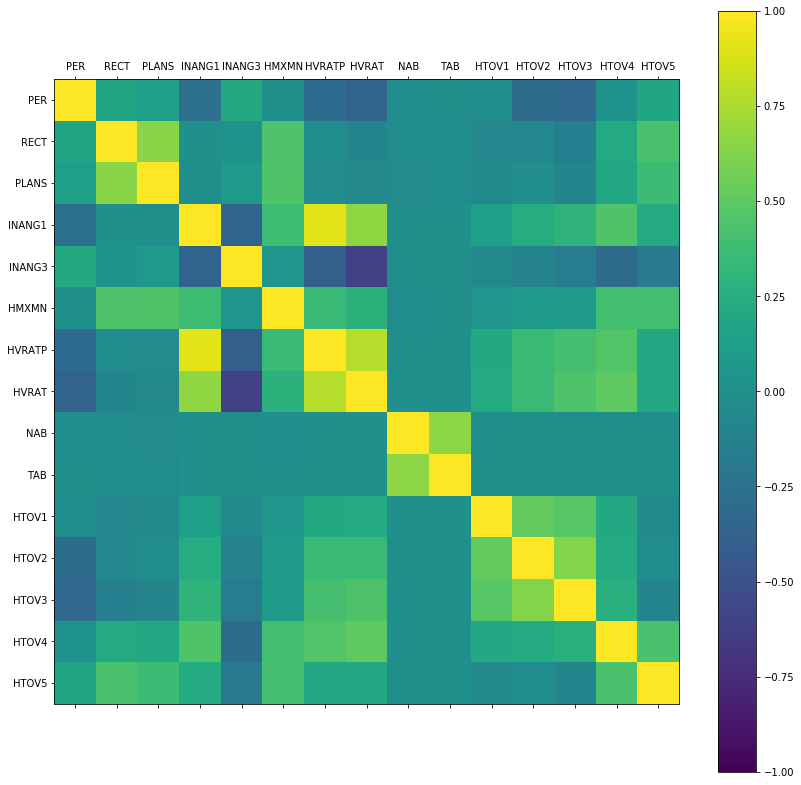

In [66]:
correlations = train[x_indices].corr()
# plot correlation matrix
fig = plt.figure(figsize=(14,14))
ax = fig.add_subplot(111)
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = numpy.arange(0,15,1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(x_indices)
ax.set_yticklabels(x_indices)

### Extract features and class labels

In [67]:
metadata

['ARID',
 'STA',
 'TIME',
 'IPHASE',
 'CLASS_IPHASE',
 'PHASE',
 'CLASS_PHASE',
 'RETIME',
 'SOURCE']

In [93]:
train_X = train[x_indices].values.astype(float)
train_Y = train[y_indices]

valid_X = valid[x_indices].values.astype(float)
valid_Y = valid[y_indices]

train_Y_ = numpy.array(numpy.where(train_Y == 'N', 1, 0), dtype=float)
valid_Y_ = numpy.array(numpy.where(valid_Y == 'N', 1, 0), dtype=float)

#convert to categorical
train_Y = keras.utils.to_categorical(train_Y_)
valid_Y = keras.utils.to_categorical(valid_Y_)

valid_metadata = valid[metadata]

print(train_X.shape, train_Y.shape, valid_X.shape, valid_Y.shape)
print(valid_metadata.shape)
print('N phases:', train_Y_.sum())

(417145, 15) (417145, 2) (21956, 15) (21956, 2)
(21956, 9)
N phases: 413367.0


### verification, that if node1 < 0.5 => N (nodes start at 1: node1, node2)

In [94]:
train[y_indices+x_indices][:10]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,N,0.333333,0.946271,0.809866,0.960533,0.411065,0.657978,0.904825,0.304160,0.1,0.1334,0.470759,-0.340777,0.344399,0.384797,-0.055565
1,N,0.444444,0.968536,0.985853,0.905435,0.684324,0.872226,0.910036,0.654238,0.0,0.0000,-0.530121,0.063211,-0.184550,0.502328,0.450416
2,N,0.444444,0.954526,0.992244,0.917408,0.601791,0.646463,0.840152,0.703805,0.0,0.0000,-0.293733,0.367974,0.313412,0.649409,0.345573
3,N,0.166667,0.856019,0.983172,0.582482,0.363260,0.274057,-0.001709,0.504575,0.0,0.0000,-0.179475,0.475204,0.091008,0.421593,0.328606
4,N,0.444444,0.882470,0.948731,0.428769,0.709052,0.185918,-0.334985,-0.161928,0.0,0.0000,-0.659006,-0.563760,0.413460,-0.507297,0.190735
5,N,0.222222,0.821793,0.798711,0.944081,0.314184,0.364120,0.590692,0.590692,0.0,0.0000,0.248588,0.209885,-0.241690,-0.035921,0.167804
6,N,0.666667,0.862530,0.938547,0.382660,0.805396,0.606317,-0.469817,0.327831,0.1,0.0680,0.128999,0.368833,0.009743,-0.149306,0.424623
7,N,0.444444,0.946453,0.990465,0.895938,0.538724,0.952360,0.622989,0.772208,0.0,0.0000,-0.617972,0.307095,-0.210831,0.805760,0.627676
8,N,0.666667,0.906109,0.984503,0.902573,0.793247,0.799316,0.445710,0.445710,0.0,0.0000,-0.355656,-0.209165,0.038603,0.333555,0.224778
9,N,0.444444,0.932397,0.966539,0.539092,0.560959,0.563008,-0.179904,-0.149919,0.0,0.0000,-0.638718,-0.367795,0.044464,-0.211527,0.359747


In [95]:
train_Y[:10]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [96]:
numpy.isnan(train_X).any()

False

#### Ground truth for all 4 classes

In [97]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(['N', 'regP', 'regS', 'T'])
valid_Y_GT = le.transform(valid[y_indices])
train_Y_GT = le.transform(train[y_indices])
print(le.transform(['N', 'regP', 'regS', 'T']))
#train_Y_GT[:200]

/dvlscratch/SHI/users/hofman/ML/venv3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 2 3 1]


# Neural network N vs TPS

#### This section is based on retime=0 data with 4 times more noise than associated phases

In [98]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD, Adam

In [99]:
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model = Sequential()
model.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))

sgd = SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=1., clipvalue=0.5)
adam = Adam(lr=0.0001) #, clipnorm, clipvalue=0.5)

model.compile(
    loss = 'binary_crossentropy', 
    optimizer = adam,  # adam, sgd
    metrics = ['accuracy'])

In [100]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6)                 96        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [101]:
hist_keys = ('acc', 'val_acc', 'loss', 'val_loss')

In [102]:
history = {k : [] for k in hist_keys}

In [122]:
class_weight = {0 : 1.,  # PST 1 to loss
                1: 0.003}  # noise = 0.1 weights to loss

h = model.fit(train_X[:], train_Y[:], 
          epochs=1, 
          batch_size=128, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=(valid_X, valid_Y),
          class_weight=class_weight)

history = {k : history[k] + h.history[k] for k in hist_keys}

Train on 417145 samples, validate on 21956 samples
Epoch 1/1
417145/417145 [==============================] - 2s 6us/step - loss: 0.0047 - acc: 0.4690 - val_loss: 0.9219 - val_acc: 0.4678


In [109]:
print(train_Y[train_Y==0].shape, train_Y[train_Y==1].shape)
print(valid_Y[valid_Y[:,0]==1].shape, valid_Y[valid_Y[:,1]==1].shape)

(417145,) (417145,)
(199, 2) (21757, 2)


In [110]:
valid_Y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

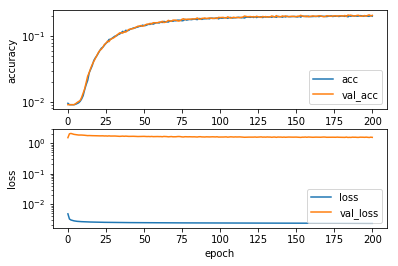

In [111]:
plot(history, semilog=True)

In [123]:
# calculate predicted values
Y_pred_ = model.predict(valid_X)
# predictions are outputted as floats from [0,1]
print(Y_pred_[:10])
print(Y_pred_.shape)
Y_pred = numpy.argmax(Y_pred_, axis=1)
Y_pred[:20]


print(Y_pred_.sum(axis=1).min(), Y_pred_.sum(axis=1).max())

from sklearn.metrics import confusion_matrix

# we must translate it to 0, 1 based on thresholding at 0.5
# where < 0.5 set to 0, to 1 otherwise
#Y_pred = numpy.where(Y_pred < 0.5, 0, 1)

# calculate confusion matrix
conf_mat = confusion_matrix(Y_pred, valid_Y_)
print(conf_mat)

[[0.69597244 0.30688694]
 [0.91911614 0.08240619]
 [0.5611135  0.43792242]
 [0.9012993  0.09642269]
 [0.61213756 0.38139483]
 [0.1315453  0.87950736]
 [0.5606069  0.430514  ]
 [0.555536   0.46563822]
 [0.5868781  0.40432787]
 [0.6869571  0.29676753]]
(21956, 2)
0.97084653 1.0380206
[[  178 11666]
 [   21 10091]]


(0.9990301, 1.0008638)

In [149]:
## confusion matrix on Train?
Y_pred = numpy.argmax(model.predict(train_X), axis=1)
conf_mat = confusion_matrix(train_Y_, Y_pred)
print(conf_mat)

[[  3302    280]
 [ 70849 135913]]


In [130]:
#eval on test data
model.evaluate(valid_X, valid_Y)

21956/21956 [==============================] - 0s 6us/step


[0.9218836925865458, 0.46775368919657495]

In [151]:
model.evaluate(train_X, train_Y)

210344/210344 [==============================] - 1s 5us/step


[0.6457675864396994, 0.6618444072566843]

In [129]:
#save model and weights, NTC = contextual features correct, Rt => retime <= t seconds
filename = f'h5/{STA}_NTPS2.h5'
model.save(filename)
print('saved as ', filename)

saved as  h5/PPT_NTPS2.h5


# Neural network TP vs S 

#### This section is based on retime=2 data

* we need a new dataset for this

## Dataset for TP vs S

In [159]:
print(TPS_train.shape, TPS_valid.shape)

(3582, 25) (398, 25)


In [287]:
train_X_TPS = TPS_train[x_indices].values.astype(float)
train_Y_TPS = TPS_train[y_indices]

valid_X_TPS = TPS_valid[x_indices].values.astype(float)
valid_Y_TPS = TPS_valid[y_indices]

#regS = 1, T/regP = 0
train_Y_TPS_ = numpy.array(numpy.where(train_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)
valid_Y_TPS_ = numpy.array(numpy.where(valid_Y_TPS['CLASS_PHASE'] == 'regS', 1, 0), dtype=float)

#convert to categorical
train_Y_TPS = keras.utils.to_categorical(train_Y_TPS_)
valid_Y_TPS = keras.utils.to_categorical(valid_Y_TPS_)

print(train_X_TPS.shape, train_Y_TPS.shape, valid_X_TPS.shape, valid_Y_TPS.shape)
print('regS:', train_Y_TPS_.sum())
print('regS:', valid_Y_TPS_.sum())

(3778, 15) (3778, 2) (199, 15) (199, 2)
regS: 6.0
regS: 1.0


### test if node3 < 0.5 => S

In [288]:
TPS_train[y_indices+x_indices][:10]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,T,1.000000,0.971745,0.955194,0.466168,0.561459,0.102762,-0.359609,-0.359609,0.0,0.0000,-0.308125,-0.650795,-0.138041,-0.171963,0.338134
1,T,0.666667,0.912641,0.789927,0.261889,0.336928,0.080796,-0.725330,0.559996,0.0,0.0000,0.070976,-0.298942,-0.354849,-0.274364,-0.185681
2,T,0.666667,0.956937,0.983625,0.124212,0.875792,0.116893,-1.193289,-1.193289,0.1,0.2710,0.269361,-0.483795,-0.038164,-0.350887,0.381465
3,T,1.000000,0.981732,0.971678,0.076740,0.946144,0.217450,-1.589549,-1.589549,0.0,0.0000,-0.172629,-0.191990,-0.476505,0.053255,0.162345
4,T,0.666667,0.796500,0.693872,0.823762,0.951695,0.457172,0.198674,-0.188126,0.1,0.0404,-0.254072,0.027715,-0.393319,-0.091662,0.104267
5,T,0.666667,0.930454,0.756333,0.141993,0.771492,0.336395,-1.018592,-0.521960,0.0,0.0000,-0.547087,0.047284,-0.191026,-0.196179,0.121747
6,T,0.666667,0.878956,0.948514,0.844549,0.965657,0.629625,0.283547,0.283547,0.0,0.0000,-0.593201,0.114971,-0.106070,0.329305,0.239427
7,T,1.000000,0.672681,0.750292,0.855294,0.480065,0.195326,0.233469,0.172953,0.0,0.0000,-0.222636,-0.365100,-0.512366,-0.118446,-0.023144
8,T,0.444444,0.977244,0.990629,0.228564,0.962667,0.522738,-1.028972,-1.263827,0.0,0.0000,-0.346046,-0.627752,-0.342169,-0.639165,0.517507
9,T,0.444444,0.751486,0.776525,0.240181,0.867893,0.280578,-0.460777,-0.265643,0.1,0.0806,-0.901270,0.326713,-0.027382,-0.344731,0.033710


In [289]:
train_Y_TPS[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### Manually added datasets for testing

In [157]:
"""
#those manually added
nsm = df_S_all[df_S_all['SOURCE'] == 'M'].shape[0]
npm = df_P_all[df_P_all['SOURCE'] == 'M'].shape[0]
ntm = df_T_all[df_T_all['SOURCE'] == 'M'].shape[0]
nnm = df_N_all[df_N_all['SOURCE'] == 'M'].shape[0]

#we build a balanced datased - the same portion of regS, regP and tele
#we have this count of phases
man_samp_count = min(nsm, npm, ntm)

#sample TPS dataset, random_state is a seed
mssS = df_S_all[df_S_all['SOURCE'] == 'M'].sample(man_samp_count, random_state=11)
mssP = df_P_all[df_P_all['SOURCE'] == 'M'].sample(man_samp_count)
mssT = df_T_all[df_T_all['SOURCE'] == 'M'].sample(man_samp_count)
MTPS_data = pd.concat([mssS, mssP, mssT])


#normalize

MTPS_data_norm = MTPS_data.copy(deep=True)
MTPS_data_norm['INANG1'] /= 90.
MTPS_data_norm['INANG3'] /= 90.
MTPS_data_norm['HMXMN'] = numpy.log10(MTPS_data['HMXMN'])
MTPS_data_norm['HVRATP'] = numpy.log10(MTPS_data['HVRATP'])
MTPS_data_norm['HVRAT'] = numpy.log10(MTPS_data['HVRAT'])
MTPS_data_norm['HTOV1'] = numpy.log10(MTPS_data['HTOV1'])
MTPS_data_norm['HTOV2'] = numpy.log10(MTPS_data['HTOV2'])
MTPS_data_norm['HTOV3'] = numpy.log10(MTPS_data['HTOV3'])
MTPS_data_norm['HTOV4'] = numpy.log10(MTPS_data['HTOV4'])
MTPS_data_norm['HTOV5'] = numpy.log10(MTPS_data['HTOV5'])

#manually added noise makes nos sense - we do not sanmple N

#lets shuffle dataset
MTPS_data_norm = MTPS_data_norm.sample(frac=1).reset_index(drop=True)

manual_X = MTPS_data_norm[x_indices].values.astype(float)
#regS = 0, T/regP = 1
manual_Y_TPS_ = numpy.array(numpy.where(MTPS_data_norm[y_indices] == 'regS', 1, 0), dtype=float)
manual_Y_TPS = keras.utils.to_categorical(manual_Y_TPS_)

print(manual_X.shape, manual_Y_TPS.shape, manual_Y_TPS_.shape)
"""

"\n#those manually added\nnsm = df_S_all[df_S_all['SOURCE'] == 'M'].shape[0]\nnpm = df_P_all[df_P_all['SOURCE'] == 'M'].shape[0]\nntm = df_T_all[df_T_all['SOURCE'] == 'M'].shape[0]\nnnm = df_N_all[df_N_all['SOURCE'] == 'M'].shape[0]\n\n#we build a balanced datased - the same portion of regS, regP and tele\n#we have this count of phases\nman_samp_count = min(nsm, npm, ntm)\n\n#sample TPS dataset, random_state is a seed\nmssS = df_S_all[df_S_all['SOURCE'] == 'M'].sample(man_samp_count, random_state=11)\nmssP = df_P_all[df_P_all['SOURCE'] == 'M'].sample(man_samp_count)\nmssT = df_T_all[df_T_all['SOURCE'] == 'M'].sample(man_samp_count)\nMTPS_data = pd.concat([mssS, mssP, mssT])\n\n\n#normalize\n\nMTPS_data_norm = MTPS_data.copy(deep=True)\nMTPS_data_norm['INANG1'] /= 90.\nMTPS_data_norm['INANG3'] /= 90.\nMTPS_data_norm['HMXMN'] = numpy.log10(MTPS_data['HMXMN'])\nMTPS_data_norm['HVRATP'] = numpy.log10(MTPS_data['HVRATP'])\nMTPS_data_norm['HVRAT'] = numpy.log10(MTPS_data['HVRAT'])\nMTPS_data

#### Manual dataset ground truth

In [269]:
"""
manual_Y_GT = le.transform(MTPS_data_norm[y_indices])
manual_Y_GT[:10]
"""

'\nmanual_Y_GT = le.transform(MTPS_data_norm[y_indices])\nmanual_Y_GT[:10]\n'

### Neural network

In [291]:
history_TPS = {k : [] for k in hist_keys}

n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TPS = Sequential()
model_TPS.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TPS.add(Dense(2, activation='sigmoid'))

model_TPS.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [292]:
model_TPS.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 6)                 96        
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 14        
Total params: 110
Trainable params: 110
Non-trainable params: 0
_________________________________________________________________


In [295]:
class_weight = {0 : 0.0001,  # PT is five times more abundant
                1: 1.}  # S = 1 weights to loss
h = model_TPS.fit(train_X_TPS[:], train_Y_TPS[:], 
          epochs=100, 
          batch_size=128, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([valid_X_TPS, valid_Y_TPS]),
          class_weight=class_weight)

history_TPS = {k : history_TPS[k] + h.history[k] for k in hist_keys}

Train on 3778 samples, validate on 199 samples
Epoch 1/100
3778/3778 [==============================] - 0s 7us/step - loss: 7.5012e-05 - acc: 0.8589 - val_loss: 0.5574 - val_acc: 0.8593
Epoch 2/100
3778/3778 [==============================] - 0s 6us/step - loss: 7.3926e-05 - acc: 0.8618 - val_loss: 0.5464 - val_acc: 0.8618
Epoch 3/100
3778/3778 [==============================] - 0s 7us/step - loss: 7.2920e-05 - acc: 0.8645 - val_loss: 0.5411 - val_acc: 0.8643
Epoch 4/100
3778/3778 [==============================] - 0s 7us/step - loss: 7.1871e-05 - acc: 0.8681 - val_loss: 0.5325 - val_acc: 0.8668
Epoch 5/100
3778/3778 [==============================] - 0s 6us/step - loss: 7.0948e-05 - acc: 0.8719 - val_loss: 0.5211 - val_acc: 0.8668
Epoch 6/100
3778/3778 [==============================] - 0s 6us/step - loss: 6.9856e-05 - acc: 0.8764 - val_loss: 0.5161 - val_acc: 0.8693
Epoch 7/100
3778/3778 [==============================] - 0s 6us/step - loss: 6.8956e-05 - acc: 0.8776 - val_loss: 0.510

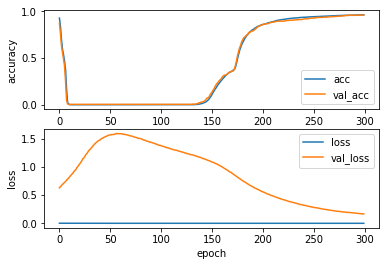

In [296]:
plot(history_TPS)

In [303]:
#NC = nodes correct
model_TPS.save(f'h5/{STA}_TPS.h5')
print(f'saved as h5/{STA}_TPS.h5')

saved as h5/PPT_TPS.h5


In [299]:
model_TPS.evaluate(valid_X_TPS, valid_Y_TPS)

199/199 [==============================] - 0s 28us/step


[0.1656141101789834, 0.9597989949748744]

In [196]:
min(valid_Y_TPS_), max(valid_Y_TPS_)
valid_Y_TPS_.shape
sum(valid_Y_TPS_)

125.0

#### Test data confusion matrix

In [297]:
Y_pred = numpy.reshape(numpy.argmax(model_TPS.predict(valid_X_TPS), axis=1), (valid_X_TPS.shape[0],1))
print(Y_pred.shape)
# calculate confusion matrix
C = confusion_matrix(valid_Y_TPS_, Y_pred)
print(C)

(199, 1)
[[190   8]
 [  0   1]]


In [300]:
Y_pred = numpy.reshape(numpy.argmax(model_TPS.predict(train_X_TPS), axis=1), (train_X_TPS.shape[0],1))
print(Y_pred.shape)
# calculate confusion matrix
Ctr = confusion_matrix(train_Y_TPS_, Y_pred)
print(Ctr)

(3778, 1)
[[3631  141]
 [   0    6]]


In [301]:
print(valid_X_TPS.shape)
print(valid_Y_TPS.shape)
print(valid_Y_TPS_.shape)
print(min(Y_pred), max(Y_pred))
print(min(valid_Y_TPS_), max(valid_Y_TPS_))
print(sum(valid_Y_TPS_), sum(Y_pred))

(199, 15)
(199, 2)
(199,)
[0] [1]
0.0 1.0
1.0 [147]


In [302]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 95.98%


# Neural network T vs regP 

#### This section is based on retime=2 data

* we need a new dataset for this

### Dataset for T vs regP

In [304]:
#exclude regS
TP_train = TPS_train[TPS_train['CLASS_PHASE'] != 'regS']
TP_valid  = TPS_valid [TPS_valid ['CLASS_PHASE'] != 'regS']

In [305]:
train_X_TP = TP_train[x_indices].values.astype(float)
train_Y_TP = TP_train[y_indices]

valid_X_TP = TP_valid[x_indices].values.astype(float)
valid_Y_TP = TP_valid[y_indices]

#regS = 0, T/regP = 1
train_Y_TP_ = numpy.array(numpy.where(train_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)
valid_Y_TP_ = numpy.array(numpy.where(valid_Y_TP['CLASS_PHASE'] == 'regP', 1, 0), dtype=float)

#convert to categorical
train_Y_TP = keras.utils.to_categorical(train_Y_TP_)
valid_Y_TP = keras.utils.to_categorical(valid_Y_TP_)

print(train_X_TP.shape, train_Y_TP.shape, valid_X_TP.shape, valid_Y_TP.shape)
print(sum(train_Y_TP_))

(3772, 15) (3772, 2) (198, 15) (198, 2)
9.0


### test if node5 < 0.5 => P

In [163]:
TP_train[y_indices + x_indices][:10]

,CLASS_PHASE,PER,RECT,PLANS,INANG1,INANG3,HMXMN,HVRATP,HVRAT,NAB,TAB,HTOV1,HTOV2,HTOV3,HTOV4,HTOV5
0,T,1.000000,0.891533,0.984187,0.111074,0.892007,0.402293,-0.905368,-0.457978,0.0,0.0000,0.629484,-0.257967,-0.369999,-0.117116,0.479116
1,T,0.666667,0.887846,0.941195,0.207367,0.896702,0.796784,-0.768232,-0.768232,0.0,-0.0680,0.162866,-0.191813,-0.465689,-0.415169,-0.063882
2,T,0.666667,0.981372,0.976986,0.143361,0.999512,0.407258,-1.345781,-1.065562,0.0,0.0000,-0.988252,-0.209086,-0.384960,-0.364016,-0.241532
3,T,0.444444,0.751486,0.776525,0.240181,0.867893,0.280578,-0.460777,-0.265643,0.1,0.0806,-0.901270,0.326713,-0.027382,-0.344731,0.033710
4,T,0.666667,0.796500,0.693872,0.823762,0.951695,0.457172,0.198674,-0.188126,0.1,0.0404,-0.254072,0.027715,-0.393319,-0.091662,0.104267
5,T,0.666667,0.930454,0.756333,0.141993,0.771492,0.336395,-1.018592,-0.521960,0.0,0.0000,-0.547087,0.047284,-0.191026,-0.196179,0.121747
6,T,0.666667,0.878956,0.948514,0.844549,0.965657,0.629625,0.283547,0.283547,0.0,0.0000,-0.593201,0.114971,-0.106070,0.329305,0.239427
7,T,0.444444,0.974282,0.919876,0.132166,0.945522,0.093667,-1.318930,-1.290402,0.0,0.0000,0.025174,0.225469,-0.249008,-0.768910,-0.240806
8,T,0.666667,0.831774,0.711320,0.059555,0.937382,0.098699,-0.762056,-0.367159,0.1,0.0432,0.251036,-0.415881,-0.342530,-0.406141,0.189963
9,T,1.000000,0.918413,0.927811,0.279318,0.783083,0.731919,-0.703260,-0.558439,0.0,0.0000,-0.317022,-0.477931,-0.226409,-0.310300,-0.369221


In [204]:
train_Y_TP[:10]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

### Neural network

In [306]:
history_TP = {k : [] for k in hist_keys}
n_input = len(x_indices)
numpy.random.seed(11)

# create model
model_TP = Sequential()
model_TP.add(Dense(6, input_dim=n_input, activation='sigmoid'))
model_TP.add(Dense(2, activation='sigmoid'))

model_TP.compile(
    loss = 'binary_crossentropy', 
    optimizer = 'adam',  # adam, sgd
    metrics = ['accuracy'])

In [165]:
npa/nta

0.0026994601079784043

In [320]:
class_weight = {0 : 0.0001,  # T is several times more abundant
                1: 1}  # P
h = model_TP.fit(train_X_TP[:], train_Y_TP[:], 
          epochs=100, 
          batch_size=128, 
          verbose=1,
          shuffle=True,
          #validation_split=0.1)
          validation_data=([valid_X_TP, valid_Y_TP]),
          class_weight=class_weight)

history_TP = {k : history_TP[k] + h.history[k] for k in hist_keys}

Train on 3772 samples, validate on 198 samples
Epoch 1/100
3772/3772 [==============================] - 0s 6us/step - loss: 4.3069e-05 - acc: 0.9104 - val_loss: 0.5048 - val_acc: 0.8990
Epoch 2/100
3772/3772 [==============================] - 0s 6us/step - loss: 4.2916e-05 - acc: 0.9109 - val_loss: 0.5090 - val_acc: 0.8990
Epoch 3/100
3772/3772 [==============================] - 0s 6us/step - loss: 4.3007e-05 - acc: 0.9112 - val_loss: 0.5028 - val_acc: 0.8990
Epoch 4/100
3772/3772 [==============================] - 0s 6us/step - loss: 4.2885e-05 - acc: 0.9113 - val_loss: 0.5112 - val_acc: 0.8990
Epoch 5/100
3772/3772 [==============================] - 0s 6us/step - loss: 4.2850e-05 - acc: 0.9104 - val_loss: 0.5114 - val_acc: 0.8990
Epoch 6/100
3772/3772 [==============================] - 0s 7us/step - loss: 4.2701e-05 - acc: 0.9108 - val_loss: 0.5096 - val_acc: 0.8990
Epoch 7/100
3772/3772 [==============================] - 0s 6us/step - loss: 4.2663e-05 - acc: 0.9108 - val_loss: 0.509

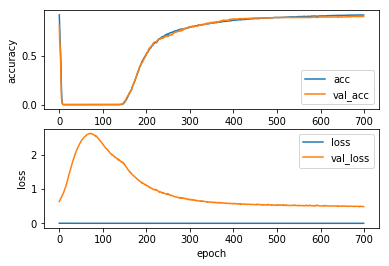

In [323]:
plot(history_TP)

In [322]:
#NC = nodes correct
model_TP.save(f'h5/{STA}_TP.h5')
print(f'saved as h5/{STA}_TP.h5')

saved as h5/PPT_TP.h5


In [168]:
model_TP.evaluate(valid_X_TP, valid_Y_TP)

396/396 [==============================] - 0s 21us/step


[0.01594696814697612, 0.9949494949494949]

#### Test data confusion matrix

In [321]:
Y_pred = numpy.reshape(numpy.argmax(model_TP.predict(valid_X_TP), axis=1), (valid_X_TP.shape[0],1))

# calculate confusion matrix
conf_mat = confusion_matrix(valid_Y_TP_, Y_pred)
print(conf_mat)

[[178  19]
 [  0   1]]


# Cascade of all three models

In [137]:
from keras.models import load_model

In [182]:
print(os.getcwd())

/dvlscratch/SHI/users/hofman/ML/stapro_nn/waveforms/notebooks/PPT


In [324]:
#STA = 'LPAZ'
# let's try URZ weights...
#model_NTPS = load_model(f'h5/LPAZ/{STA}_NTPS4.h5')
#model_STP = load_model(f'h5/LPAZ/{STA}_TPS.h5')
#model_PT = load_model(f'h5/LPAZ/{STA}_TP.h5')

model_NTPS = load_model(f'h5/{STA}_NTPS1.h5')
model_STP = load_model(f'h5/{STA}_TPS.h5')
model_PT = load_model(f'h5/{STA}_TP.h5')

In [145]:
def predict_iwt(X, stage=0):
    """
    predicts initial wave type for given featrue vectors
    Class encoding generated by sklearn Label Encoder
    0 - noise
    2 - regS 
    1 - regP
    3 - T
    """
    Y = numpy.arange(X.shape[0])
    
    N_indices = None
    S_indices = None 
    
    if stage >= 1:
        N_indices = [False] * X.shape[0]
        X_PTS = X
        Y_NPTS = numpy.zeros(X.shape[0])
    if stage >= 2:
        S_indices =  [False] * X.shape[0]  # numpy.array([])
        X_PT = X
        Y_PTS = numpy.zeros(X.shape[0])
        
    
    """
    N vs regS, regP, T
    """
    if N_indices is None:
        #predict N vs T,regP,regS
        Y_NPTS = numpy.argmax(model_NTPS.predict(X), axis=1)
        #set which are noise
        N_indices = Y[Y_NPTS == 1]  #  = 0
        #get candidates for TPS
        X_PTS = X[Y_NPTS < 1]
    else:
        print('Skipping N, classifying TPS only')

    """
    regS vs regP, T
    """
    if S_indices is None:    
        #predict regS vs T,regP
        Y_PTS = numpy.argmax(model_STP.predict(X_PTS), axis=1)
        #set which are regS
        S_indices = Y[Y_NPTS < 1][Y_PTS == 1]  # = 2
        #get candidates for regP,T
        X_PT = X_PTS[Y_PTS < 1]
    else:
        print('Skipping N, regS, classifying TP only')

    """
    regP vs T
    """
    #predict regP vs T
    Y_PT = numpy.argmax(model_PT.predict(X_PT), axis=1)
    #set which are regP
    P_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT == 1]  # = 1    
    #set which are T
    T_indices = Y[Y_NPTS < 1][Y_PTS < 1][Y_PT < 1]   # = 3
    #get those which are T
    X_T = X_PT[Y_PT < 1]
    
    Y[N_indices] = 0 # 0 # N
    Y[S_indices] = 3 # 2 # regS
    Y[P_indices] = 2 # 1 # regP 
    Y[T_indices] = 1 # 3 # tele
    
    return Y
    

In [326]:
Y = predict_iwt(valid_X)

### Overall confusion matrix for test data 

In [327]:
valid_X.shape, Y.shape, valid_Y_GT.shape

((11686, 15), (11686,), (11686,))

In [328]:
from sklearn.metrics import confusion_matrix
C = confusion_matrix(Y, valid_Y_GT)
print(C)

[[8596   28    0    1]
 [2515  152    0    0]
 [ 254   15    1    0]
 [ 122    2    0    0]]


In [329]:
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

Accuracy: 74.87%


#### Let's produce result data frame from metadata and results (with retime=0)

In [330]:
test_metadata = valid[metadata]

In [331]:
### some experiment section..

In [332]:
valid_pred_Y = predict_iwt(valid_X)

In [333]:
valid_X.shape

(11686, 15)

In [334]:
valid_iphase_Y = le.transform(valid['CLASS_IPHASE'])
valid_truth_Y = le.transform(valid['CLASS_PHASE'])

In [335]:
valid_truth_Y.min(), valid_truth_Y.max()

(0, 3)

In [336]:
valid_iphase_Y.min(), valid_iphase_Y.max()

(0, 3)

In [337]:
#print('IPHASE:')
C = confusion_matrix(valid_pred_Y, valid_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[8596   28    0    1]
 [2515  152    0    0]
 [ 254   15    1    0]
 [ 122    2    0    0]]
Accuracy: 74.87%


### Test data just regS, regP, T - not to be confused with overall statistics on all arrivals in our DB

In [338]:
valid_TPS = valid[valid['CLASS_PHASE'] != 'N']
valid_TPS_X = valid_TPS[x_indices]
valid_TPS_pred_Y = predict_iwt(valid_TPS_X)
valid_TPS_truth_Y = le.transform(valid_TPS['CLASS_PHASE'])
valid_TPS_iphase_Y = le.transform(valid_TPS['CLASS_IPHASE'])

In [339]:
valid_TPS_iphase_Y.min(), valid_TPS_iphase_Y.max()

(0, 3)

In [340]:
print('IPHASE:')
C = confusion_matrix(valid_TPS_iphase_Y, valid_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

IPHASE:
[[  0  24   0   0]
 [  0 140   1   0]
 [  0  27   0   0]
 [  0   6   0   1]]
Accuracy: 70.85%


In [341]:
print('NEW PREDICTION')
C = confusion_matrix(valid_TPS_pred_Y, valid_TPS_truth_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

NEW PREDICTION
[[  0  28   0   1]
 [  0 152   0   0]
 [  0  15   1   0]
 [  0   2   0   0]]
Accuracy: 76.88%


* in the test data, the current iwt characterized 166 as NOISE (first row of confusion matrix)
* our new iwt would characterize 49 as NOISE
* after re-training, accuracy on the test set rose from 59.14% to 71.53% for regS, regP and T phases

# Prediction on 2018

### Load data

In [138]:
STA = 'PPT'
query = f"select * from ml_features where sta='{STA}' and class_phase='regS' and time > {ts_2018}"
df_S_2017 = pd.read_sql(query, con=connection)
query = f"select * from ml_features where sta='{STA}' and class_phase='regP' and time > {ts_2018}"
df_P_2017 = pd.read_sql(query, con=connection)
query = f"select * from ml_features where sta='{STA}' and class_phase='T' and time > {ts_2018}"
df_T_2017 = pd.read_sql(query, con=connection)
query = f"select * from ml_features where sta='{STA}' and class_phase='N' and time > {ts_2018}"
df_N_2017 = pd.read_sql(query, con=connection)
print(df_S_2017.shape, df_P_2017.shape, df_T_2017.shape, df_N_2017.shape)

(0, 25) (1, 25) (554, 25) (46673, 25)


In [146]:
data_2017 = pd.concat([df_P_2017, df_S_2017, df_T_2017])
data_2017_wN = pd.concat([df_P_2017, df_S_2017, df_T_2017, df_N_2017])

In [147]:
test_TPS_iphase_Y_2017 = le.transform(data_2017['CLASS_IPHASE'])

In [148]:
data_2017_X = data_2017[x_indices]

data_2017_norm = data_2017[x_indices].copy(deep=True)
data_2017_norm['INANG1'] /= 90.
data_2017_norm['INANG3'] /= 90.
data_2017_norm['HMXMN'] = numpy.log10(data_2017_X['HMXMN'])
data_2017_norm['HVRATP'] = numpy.log10(data_2017_X['HVRATP'])
data_2017_norm['HVRAT'] = numpy.log10(data_2017_X['HVRAT'])
data_2017_norm['HTOV1'] = numpy.log10(data_2017_X['HTOV1'])
data_2017_norm['HTOV2'] = numpy.log10(data_2017_X['HTOV2'])
data_2017_norm['HTOV3'] = numpy.log10(data_2017_X['HTOV3'])
data_2017_norm['HTOV4'] = numpy.log10(data_2017_X['HTOV4'])
data_2017_norm['HTOV5'] = numpy.log10(data_2017_X['HTOV5'])

data_2017_X_wN = data_2017_wN[x_indices]

data_2017_norm_wN = data_2017_wN[x_indices].copy(deep=True)
data_2017_norm_wN['INANG1'] /= 90.
data_2017_norm_wN['INANG3'] /= 90.
data_2017_norm_wN['HMXMN'] = numpy.log10(data_2017_X_wN['HMXMN'])
data_2017_norm_wN['HVRATP'] = numpy.log10(data_2017_X_wN['HVRATP'])
data_2017_norm_wN['HVRAT'] = numpy.log10(data_2017_X_wN['HVRAT'])
data_2017_norm_wN['HTOV1'] = numpy.log10(data_2017_X_wN['HTOV1'])
data_2017_norm_wN['HTOV2'] = numpy.log10(data_2017_X_wN['HTOV2'])
data_2017_norm_wN['HTOV3'] = numpy.log10(data_2017_X_wN['HTOV3'])
data_2017_norm_wN['HTOV4'] = numpy.log10(data_2017_X_wN['HTOV4'])
data_2017_norm_wN['HTOV5'] = numpy.log10(data_2017_X_wN['HTOV5'])

In [149]:
data_2017_Y = numpy.zeros(data_2017.shape[0])
data_2017_Y[:df_P_2017.shape[0]] = 2
data_2017_Y[df_P_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]] = 3
data_2017_Y[df_P_2017.shape[0]+df_S_2017.shape[0]:] = 1

data_2017_Y_wN = numpy.zeros(data_2017_wN.shape[0])
data_2017_Y_wN[:df_P_2017.shape[0]] = 2
data_2017_Y_wN[df_P_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]] = 3
data_2017_Y_wN[df_P_2017.shape[0]+df_S_2017.shape[0]:df_P_2017.shape[0]+df_S_2017.shape[0]+df_T_2017.shape[0]] = 1

### Predict and evaluate

In [160]:
model_NTPS = load_model(f'h5/{STA}_NTPS1.h5')
model_STP = load_model(f'h5/{STA}_TPS.h5')
model_PT = load_model(f'h5/{STA}_TP.h5')

In [161]:
data_2017_pred = predict_iwt(data_2017_norm)
data_2017_pred_wN = predict_iwt(data_2017_norm_wN)

In [162]:
C = confusion_matrix(data_2017_pred, data_2017_Y)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
nphaserate = C[0,:].sum()/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))
print('N phase rate: %3.2f%%' % (nphaserate*100))

[[  0  74   0   0]
 [  0 398   0   0]
 [  0  80   1   0]
 [  0   2   0   0]]
Accuracy: 71.89%
N phase rate: 13.33%


In [163]:
C = confusion_matrix(data_2017_pred_wN, data_2017_Y_wN)
print(C)
diagsum = numpy.diag(C).sum()
tot_accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (tot_accuracy*100))

[[36987    74     0     0]
 [ 8811   398     0     0]
 [  254    80     1     0]
 [  621     2     0     0]]
Accuracy: 79.16%


In [370]:
summary = "Training summary: Accuracy: %3.2f%%, assoc accuracy: %3.2f%%, Nphaserate: %3.2f%%, assoc. ph: %d, noise ph: %d" % (tot_accuracy*100, accuracy*100, nphaserate*100, data_2017_norm.shape[0], data_2017_norm_wN.shape[0])
print(summary)

Training summary: Accuracy: 80.85%, assoc accuracy: 71.89%, Nphaserate: 13.33%, assoc. ph: 555, noise ph: 27500


In [355]:
 data_2017_Y_wN.shape

(27500,)

In [356]:
print('N', data_2017_Y_wN[data_2017_Y_wN==0].shape)
print('P', data_2017_Y_wN[data_2017_Y_wN==1].shape)
print('S', data_2017_Y_wN[data_2017_Y_wN==2].shape)
print('T', data_2017_Y_wN[data_2017_Y_wN==3].shape)

N (26945,)
P (554,)
S (1,)
T (0,)


## Overall results on train data just to see if it works...

In [359]:
Y = predict_iwt(train_X)
C = confusion_matrix(Y, train_Y_GT)
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[163196    511      3      4]
 [ 48400   2986      0      0]
 [  4514    230      6      0]
 [  2139     36      0      2]]
Accuracy: 74.85%


# Let's analyze weights and generate a new NN weight file!

In [360]:
model_NTPS = load_model(f'h5/{STA}_NTPS1.h5')
model_STP = load_model(f'h5/{STA}_TPS.h5')
model_PT = load_model(f'h5/{STA}_TP.h5')

In [361]:
weights_NTPS = model_NTPS.get_weights()
weights_STP = model_STP.get_weights()
weights_PT = model_PT.get_weights()

In [371]:
model_NTPS.get_config()

[{'class_name': 'Dense',
  'config': {'name': 'dense_7',
   'trainable': True,
   'batch_input_shape': (None, 15),
   'dtype': 'float32',
   'units': 6,
   'activation': 'sigmoid',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'scale': 1.0,
     'mode': 'fan_avg',
     'distribution': 'uniform',
     'seed': None}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'kernel_regularizer': None,
   'bias_regularizer': None,
   'activity_regularizer': None,
   'kernel_constraint': None,
   'bias_constraint': None}},
 {'class_name': 'Dense',
  'config': {'name': 'dense_8',
   'trainable': True,
   'units': 2,
   'activation': 'sigmoid',
   'use_bias': True,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'scale': 1.0,
     'mode': 'fan_avg',
     'distribution': 'uniform',
     'seed': None}},
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'kernel_regularizer': None,
   'bias_regulari

In [372]:
for w in weights_NTPS:
    print(w.shape)

(15, 6)
(6,)
(6, 2)
(2,)


In [373]:
for w in weights_STP:
    print(w.shape)
    print(w)

(15, 6)
[[-1.2525536  -1.7977294   1.6312222  -1.6645693  -1.4433973  -1.4102014 ]
 [-0.2944614  -0.032478   -0.08378378 -0.27684098 -0.1427236  -0.16827248]
 [ 0.01515137 -0.5936641  -0.17512581 -0.41662154 -0.02102235 -0.33748472]
 [-0.3136627  -0.3507385  -0.44138423 -0.3140153  -0.48512155  0.05448603]
 [-1.329746   -0.7074329   0.6409115  -0.7107964  -0.973383   -1.014864  ]
 [-0.360411   -0.20618342  0.42094734  0.42625824  0.04743637 -0.2855544 ]
 [ 0.64549136  0.7732364  -0.4002605   0.72155905  0.6532652   0.6737851 ]
 [ 2.0641625   2.3277793  -1.287662    1.7950078   1.8720689   1.7464548 ]
 [-0.9436114  -1.3475462   1.2280846  -0.44625807 -0.9042087  -0.87922156]
 [-1.2519664  -0.9023044   0.99309736 -1.5131085  -1.381773   -1.8777874 ]
 [ 0.04564335 -0.548299   -0.19238997 -0.31490198 -0.07724503  0.08982157]
 [ 2.2178586   2.173919   -1.5405072   1.5566094   2.0575967   2.1208227 ]
 [ 0.3445739   0.2592745  -0.24075334  0.4970413   0.51151335  0.4652763 ]
 [ 2.9567792   2.

In [374]:
for w in weights_PT:
    print(w.shape)
    print(w)

(15, 6)
[[-3.0966594  -3.3870852   3.4809017  -3.3718023  -3.2325218  -3.2737505 ]
 [-0.36239815  0.03784184  0.10750474 -0.30931076 -0.13475932 -0.26163307]
 [-0.4907986  -0.9453788   0.39242977 -0.8691837  -0.4621667  -0.84869313]
 [-1.3895221  -1.4984422   0.9436189  -1.2383969  -1.5685357  -1.1270132 ]
 [-0.08132224  0.5595303  -0.27701598  0.3691406   0.23382147  0.2701797 ]
 [ 1.3613405   1.6523377  -1.1004909   2.013484    1.7897192   1.4023279 ]
 [ 0.26285163  0.56084156 -0.17647277  0.46039373  0.45123616  0.3628512 ]
 [-0.9690341  -0.64313334  1.119365   -0.7922022  -0.8145766  -1.1326159 ]
 [ 2.2163591   1.7148592  -1.5176727   2.3652587   1.9432908   2.1781538 ]
 [ 1.7356023   1.8896075  -1.5527085   1.1181655   1.3104678   1.1190364 ]
 [ 1.3453252   1.0623788  -1.1612855   1.067479    1.0752438   1.1776298 ]
 [ 0.26444623  0.49199906 -0.08436318  0.17467648  0.4481833   0.3751357 ]
 [ 3.503947    3.1784568  -2.844585    2.9509828   3.3007994   3.4395945 ]
 [-0.8787962  -1.

### Let's export it to a weigth file using a template

In [375]:
station_name = STA

In [376]:
# open template
with open(os.path.join('../templates','weight_file.template')) as f:
    template = f.read()
    #print(s)

In [377]:
import datetime
#put name to template
s = template.replace('{{station_name}}', station_name)
s = s.replace('{{date}}', datetime.datetime.now().strftime('%Y/%m/%d %H:%M:%S'))
s = s.replace('{{training_summary}}', summary)

In [378]:
weight_idents = ('TPSN', 'TPS', 'TP')
weights = (weights_NTPS, weights_STP, weights_PT)

In [379]:
#prepare weights
for ident, w in zip(weight_idents, weights):
    weights_layer_1 = ""
    for i in range(w[0].shape[0]):
        weights_layer_1 += ' '.join(list(map(lambda x: "%7.6f" % x, w[0][i,:])))
        if i < w[0].shape[0] - 1:
            weights_layer_1  += '\n'        
        
    bias_layer_1 = ' '.join(list(map(lambda x: "%7.6f" % x, w[1])))
    
    weights_layer_2 = ""
    for i in range(w[2].shape[0]):
        weights_layer_2 += ' '.join(list(map(lambda x: "%7.6f" % x, w[2][i,:])))
        if i < w[2].shape[0] - 1:
            weights_layer_2  += '\n'        
        
    bias_layer_2 = ' '.join(list(map(lambda x: "%7.6f" % x, w[3])))
    
    #put coefficients into template
    s = s.replace('{{%s_bias_layer_1}}' % ident, bias_layer_1) 
    s = s.replace('{{%s_weights_layer_1}}' % ident, weights_layer_1)
    s = s.replace('{{%s_bias_layer_2}}' % ident, bias_layer_2)
    s = s.replace('{{%s_weights_layer_2}}' % ident, weights_layer_2)
    
#print(bias_layer_1)
#print(weights_layer_1)
#print(bias_layer_2)
#print(weights_layer_2)

In [380]:
print(s)

*-- PPT.nn
*-- Comments ...
*-- Auxiliary 3C station PPT uses the new weights from retraining by RH
*-- Generated 2019/10/17 10:24:54
*-- Training summary: Accuracy: 80.85%, assoc accuracy: 71.89%, Nphaserate: 13.33%, assoc. ph: 555, noise ph: 27500
PPT
3
60.000000
  0.25   0.50   1.00   2.00   4.00
PPT TPS-N
628 3 16 7 2
-2.340505 -2.154040 -1.157381 1.500167 -1.327089 -2.186604
-1.377546 -1.404558 4.961841 -0.591482 -0.018042 0.444229
1.556576 1.181883 1.028301 -1.410546 1.672799 1.062860
0.021444 -1.104644 -0.459597 0.069482 -0.070249 -0.765357
-2.746356 0.276495 -0.205263 -0.876031 0.471450 0.153308
-0.380921 -0.433752 -0.367412 -0.017472 0.405212 -0.553786
0.929938 0.419192 0.454559 0.344465 0.230583 0.373085
-3.208685 0.106935 -0.224000 -0.043144 0.057980 -3.322788
2.696220 -1.399364 -0.528261 -0.206671 0.728220 -3.362570
6.131959 5.412809 -3.030017 -11.934106 14.516894 4.454782
-1.927457 -1.206185 -4.068640 1.093556 -1.237277 -2.323246
1.090779 -1.462742 -0.180014 -0.146227 0.06

In [381]:
#save it
with open(os.path.join('nn_weights','%s.nn' % station_name), 'w+') as f:
    f.write(s)

### Experiment if the weight from C code gives the same results as here

arid=119744643 
 
Before normalization:
(1.000000,0.966347,0.977263,8.234518,88.750600,2.412571,0.044210,0.044210,0.300000,0.507750,1.166405,0.288975,0.655635,0.703711,0.243465) nab=0.300000 tab=0.507750

Normalized: 
(1.000000,0.966347,0.977263,0.091495,0.986118,0.382480,-1.354475,-1.354475,0.300000,0.507750,0.066849,-0.539140,-0.183338,-0.152606,-0.613563) nab=0.300000 tab=0.507750

results of stages in C code (StaPro):
+++++ TPS-N: arid=119744643  node1=0.667373 node2=0.332627
+++++ TP-S: arid=119744643  node3=0.991951 node4=0.007760
+++++ T-P: arid=119744643  node5=0.862848 node6=0.137152


In [133]:
input = numpy.reshape(numpy.array([1.000000,0.966347,0.977263,0.091495,0.986118,0.382480,-1.354475,-1.354475,0.300000,0.507750,0.066849,-0.539140,-0.183338,-0.152606,-0.613563]), (1,15))
print('TPS-N:', model_NTPS.predict(input))
print('TP-S :', model_STP.predict(input))
print('T-P  :', model_PT.predict(input))

TPS-N: [[0.66737413 0.3326257 ]]
TP-S : [[0.9919511  0.00776022]]
T-P  : [[0.86284804 0.13715191]]


# URZ DVL evaluation after one month

* we let the new NN classifier run for more than one month and than analysed the data (2018/07/25-2018/09/04)
* 3251 arrivals in total, 370 associated of that
* arrivals in IDCDEV and ODB are paired by proximity in time and azimuth to be sure

In [127]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

In [16]:
query = """select * from urz_eval_oct2"""
urz_eval = pd.read_sql(query, con=connection)

In [17]:
urz_eval

,ARID_DEV,ARID_ODB,TIME_DEV,TIME_ODB,AZI_DEV,AZI_ODB,IPHASE_DEV,IPHASE_ODB,ASSOC_PHASE,CLASS_IPHASE_DEV,CLASS_IPHASE_ODB,CLASS_PHASE_ODB,NCLS_IPHASE_DEV,NCLS_IPHASE_ODB,NCLS_PHASE_ODB
0,126374191,134713582,1.534748e+09,1.534748e+09,356.882510,356.882510,P,P,P,T,T,T,3,3,3
1,126375785,134715306,1.534753e+09,1.534753e+09,12.079766,12.079792,P,N,P,T,N,T,3,0,3
2,126376162,134715666,1.534755e+09,1.534755e+09,347.864520,347.864530,P,P,P,T,T,T,3,3,3
3,126379946,134718854,1.534764e+09,1.534764e+09,348.731750,348.731750,P,P,P,T,T,T,3,3,3
4,126379947,134718855,1.534764e+09,1.534764e+09,344.056190,344.056190,Sx,Sx,S,regS,regS,T,2,2,3
5,126380309,134719333,1.534765e+09,1.534765e+09,38.220733,38.220719,P,P,P,T,T,T,3,3,3
6,126381080,134720125,1.534767e+09,1.534767e+09,50.938620,50.938665,P,N,P,T,N,T,3,0,3
7,126384271,134723901,1.534779e+09,1.534779e+09,355.845540,355.845600,P,P,P,T,T,T,3,3,3
8,126385494,134725045,1.534784e+09,1.534784e+09,348.251760,348.251770,P,P,P,T,T,T,3,3,3
9,126387228,134726675,1.534790e+09,1.534790e+09,7.380147,7.380175,P,N,P,T,N,T,3,0,3


In [18]:
from sklearn.metrics import confusion_matrix

### Confusion matrix with new weights

In [19]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_DEV'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[2042    3    8   11]
 [ 503   84    1   60]
 [ 719    2   83   64]
 [ 485    8    0  170]]
Accuracy: 56.07%


In [136]:
numpy.diag(C)/C.sum(axis=0)

array([0.54467858, 0.86597938, 0.90217391, 0.55737705])

In [137]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.6821862348178138

In [134]:
#August:

### Confusion matrix with old weights

In [138]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_ODB'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[1879    9   33   48]
 [ 497   76    2   83]
 [ 439    2   56   39]
 [ 934   10    1  135]]
Accuracy: 50.58%


In [139]:
numpy.diag(C)/C.sum(axis=0)

array([0.50120032, 0.78350515, 0.60869565, 0.44262295])

In [140]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.5404858299595142

In [141]:
#August:

In [142]:
C.sum()

4243

# URZ TST evaluation after some time

* we let the new NN classifier run for more than one month and than analysed the data (2018/10/09-2018/11/20)
* 3412 arrivals in total, 336 associated of that
* arrivals in TST and ODB are paired by proximity in time and azimuth to be sure

In [7]:
#load data from oracle do pandas
import cx_Oracle
connection = cx_Oracle.connect('hofman', password, 'udb')

In [20]:
query = """select * from urz_eval_tst"""
urz_eval = pd.read_sql(query, con=connection)

In [21]:
urz_eval

,ARID_DEV,ARID_ODB,TIME_DEV,TIME_ODB,AZI_DEV,AZI_ODB,IPHASE_DEV,IPHASE_ODB,ASSOC_PHASE,CLASS_IPHASE_DEV,CLASS_IPHASE_ODB,CLASS_PHASE_ODB,NCLS_IPHASE_DEV,NCLS_IPHASE_ODB,NCLS_PHASE_ODB
0,163155867,135993887,1.539090e+09,1.539090e+09,94.184126,94.184126,Lg,Sx,None,regS,regS,N,2,2,0
1,163158494,135997160,1.539099e+09,1.539099e+09,157.894260,157.894260,N,P,None,N,T,N,0,3,0
2,163158495,135997161,1.539099e+09,1.539099e+09,90.380756,90.380756,N,P,None,N,T,N,0,3,0
3,163158496,135997162,1.539099e+09,1.539099e+09,141.813570,141.813570,P,N,None,T,N,N,3,0,0
4,163158497,135997163,1.539099e+09,1.539099e+09,337.098900,337.098900,P,N,None,T,N,N,3,0,0
5,163159717,135998298,1.539103e+09,1.539103e+09,67.040294,67.040239,N,P,None,N,T,N,0,3,0
6,163160579,135999173,1.539105e+09,1.539105e+09,240.753160,240.753160,N,P,None,N,T,N,0,3,0
7,163161374,135999686,1.539107e+09,1.539107e+09,345.969390,345.969390,Pn,Pn,P,regP,regP,T,1,1,3
8,163161375,135999687,1.539107e+09,1.539107e+09,342.179640,342.179600,Px,N,None,regP,N,N,1,0,0
9,163161376,135999688,1.539107e+09,1.539107e+09,77.486684,77.487341,Pn,N,None,regP,N,N,1,0,0


In [22]:
from sklearn.metrics import confusion_matrix

### Confusion matrix with new weights

In [33]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_DEV'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100), C.sum())

[[1626    1    4    8]
 [ 341   46    1   38]
 [ 489    1   51   47]
 [ 459    6    1  132]]
Accuracy: 57.06% 3251


In [29]:
numpy.diag(C)/C.sum(axis=0)

array([0.55780446, 0.85185185, 0.89473684, 0.58666667])

### accuracy associated

In [30]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.6815476190476191

### Confusion matrix with old weights

In [31]:
C = confusion_matrix(urz_eval['NCLS_IPHASE_ODB'], urz_eval['NCLS_PHASE_ODB'])
print(C)
diagsum = numpy.diag(C).sum()
accuracy = diagsum/C.sum()
print('Accuracy: %3.2f%%' % (accuracy*100))

[[1470    6   22   29]
 [ 380   44    5   55]
 [ 342    1   30   29]
 [ 723    3    0  112]]
Accuracy: 50.94%


### accuracy associated

In [32]:
numpy.sum(numpy.diag(C)[1:])/numpy.sum(C.sum(axis=0)[1:])

0.5535714285714286